# Goodwin's oscillator toy model

This example shows how the Goodwin's Oscillator toy model can be used.

Our version of this model has five parameters and three oscillating states as described in [1].

[1] Estimating Bayes factors via thermodynamic integration and population MCMC. Ben Calderhead and Mark Girolami, 2009, Computational Statistics and Data Analysis.

In [1]:
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np
import time

model = pints.toy.GoodwinOscillatorModel()

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
real_parameters = model.suggested_parameters()
print(real_parameters)

[2.   4.   0.12 0.08 0.1 ]


In the same way, we can get a suggested set of sampling times:

In [3]:
times = model.suggested_times()

Now we can run a simulation:

In [4]:
values = model.simulate(real_parameters, times)

This gives us all we need to create a plot of current versus time:

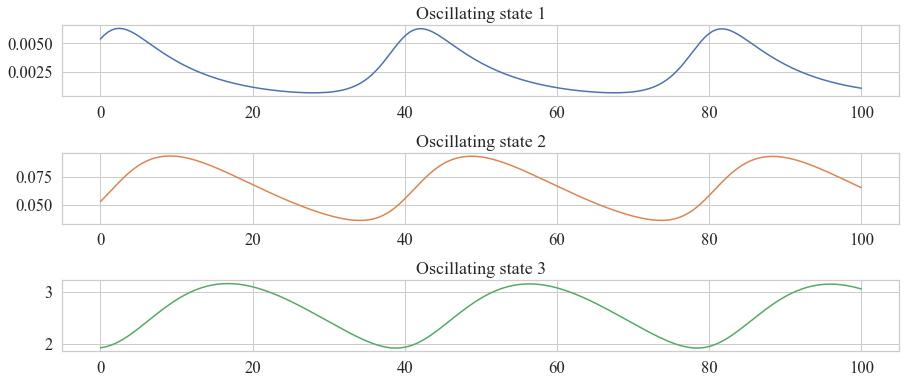

In [5]:
import seaborn as sns
import itertools
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
palette = itertools.cycle(sns.color_palette())

plt.figure(figsize=(15,6))
plt.subplot(3, 1, 1)
plt.plot(times, values[:, 0], c=next(palette))
plt.title('Oscillating state 1')
plt.subplot(3, 1, 2)
plt.plot(times, values[:, 1], c=next(palette))
plt.title('Oscillating state 2')
plt.subplot(3, 1, 3)
plt.plot(times, values[:, 2], c=next(palette))
plt.subplots_adjust(wspace=0, hspace=0.8)
plt.title('Oscillating state 3')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

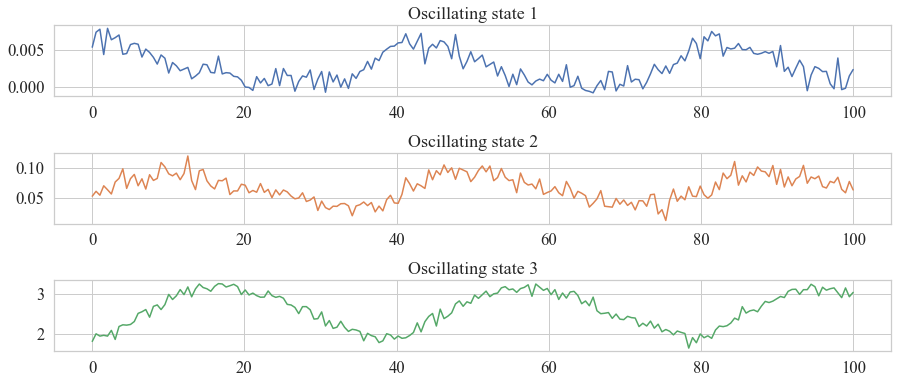

In [6]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
palette = itertools.cycle(sns.color_palette())

noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure(figsize=(15,6))
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], c=next(palette))
plt.title('Oscillating state 1')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], c=next(palette))
plt.title('Oscillating state 2')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], c=next(palette))
plt.subplots_adjust(wspace=0, hspace=0.8)
plt.title('Oscillating state 3')
plt.show()

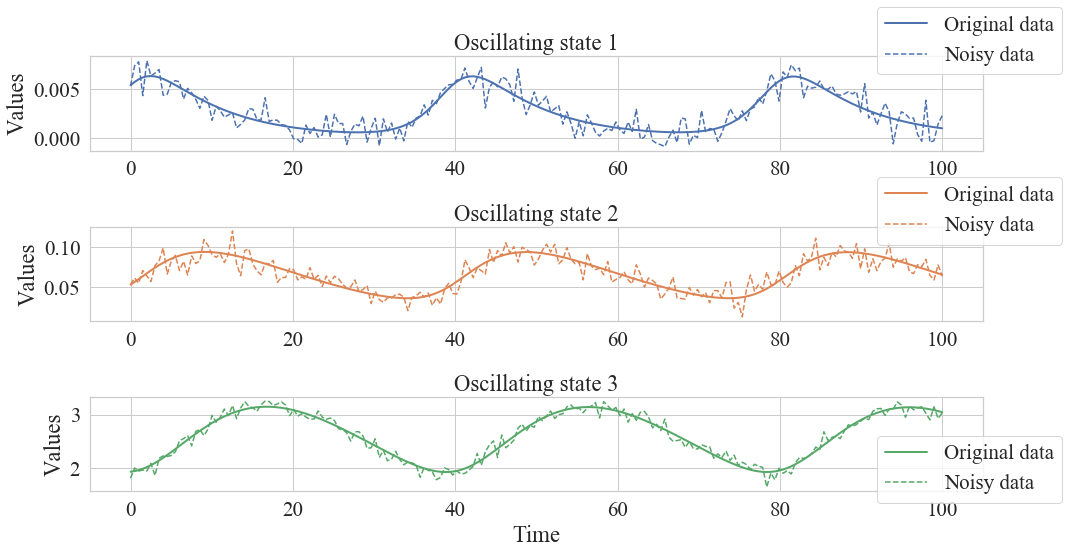

In [43]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.9, color_codes=True, rc={"grid.linewidth": 1})
palette = itertools.cycle(sns.color_palette())

fig = plt.figure(figsize=(16,8))
ax = plt.subplot(3, 1, 1)
c=next(palette)
plt.plot(times, values[:, 0], lw=2, c=c, label='Original data')
plt.plot(times, noisy_values[:, 0], '--', c=c, label='Noisy data')
plt.title('Oscillating state 1')
plt.ylabel('Values')
ax.legend(bbox_to_anchor=(0.87, 0.7))

ax = plt.subplot(3, 1, 2)
c=next(palette)
plt.plot(times, values[:, 1], lw=2, c=c, label='Original data')
plt.plot(times, noisy_values[:, 1], '--', c=c, label='Noisy data')
plt.title('Oscillating state 2')
plt.ylabel('Values')
ax.legend(bbox_to_anchor=(0.87, 0.7))

ax = plt.subplot(3, 1, 3)
c=next(palette)
plt.plot(times, values[:, 2], lw=2, c=c, label='Original data')
plt.plot(times, noisy_values[:, 2], '--', c=c, label='Noisy data')
plt.subplots_adjust(wspace=0, hspace=0.8)
plt.title('Oscillating state 3')
plt.ylabel('Values')
plt.xlabel('Time')
ax.legend(bbox_to_anchor=(0.87, 0.7))
plt.show()
fig.savefig("figures/goodwin.png", bbox_inches='tight', dpi=600)

Now we can try and infer the original parameters:

In [8]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
bounds = pints.RectangularBoundaries([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
#bounds = [1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1]
log_prior = pints.UniformLogPrior(bounds)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
chains = mcmc.run()
print('Done!')

end = time.time()
diff = end - start

Running
Done!


Print results.

In [9]:
results = pints.MCMCSummary(chains=chains, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       2.70    1.42    1.59    1.95   2.02   2.27   5.93     1.50    23.91  0.23
k3       3.97    0.96    1.87    3.78   4.01   4.20   5.79     1.34    27.35  0.26
m1       0.15    0.12    0.07    0.12   0.12   0.12   0.69     1.17    26.04  0.25
m2       0.09    0.06    0.03    0.08   0.08   0.08   0.31     1.24    24.14  0.23
m3       0.10    0.03    0.05    0.10   0.10   0.11   0.16     1.23    33.44  0.32


Now we can inspect the resulting chains:

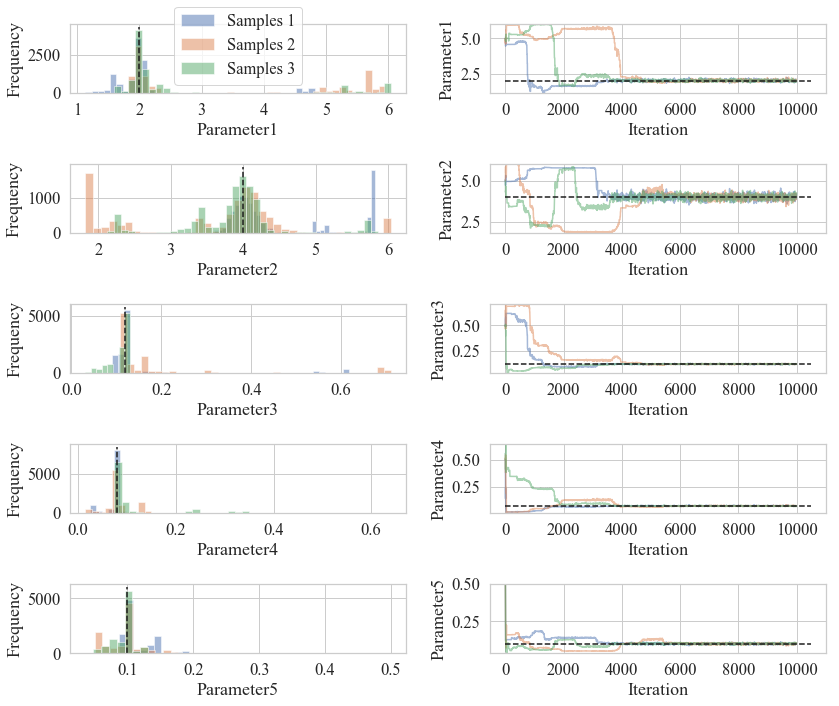

In [10]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

This is a pretty hard problem!

Plot posterior predictive distribution.

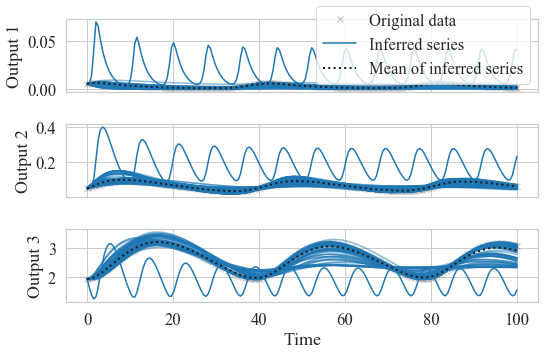

In [11]:
pints.plot.series(np.vstack(chains), problem)
plt.show()

In [12]:
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

[5.995059819560501,
 2.899685588007128,
 4.799551511985067,
 7.1294362486716425,
 9.211629381111893]

In [13]:
input_parameters[:5]

array([[5.99505982, 9.19359644, 0.23766808, 0.85000644, 0.13802727],
       [2.89968559, 8.36719246, 0.45237683, 0.05660779, 0.04784118],
       [4.79955151, 1.71583254, 0.42874098, 0.06566626, 0.80456472],
       [7.12943625, 4.23645643, 0.34785663, 0.66589564, 0.7604138 ],
       [9.21162938, 6.19170419, 0.09217784, 0.06011179, 0.46483563]])

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=128, hidden_activation='tanh', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
_________________________________________________________________


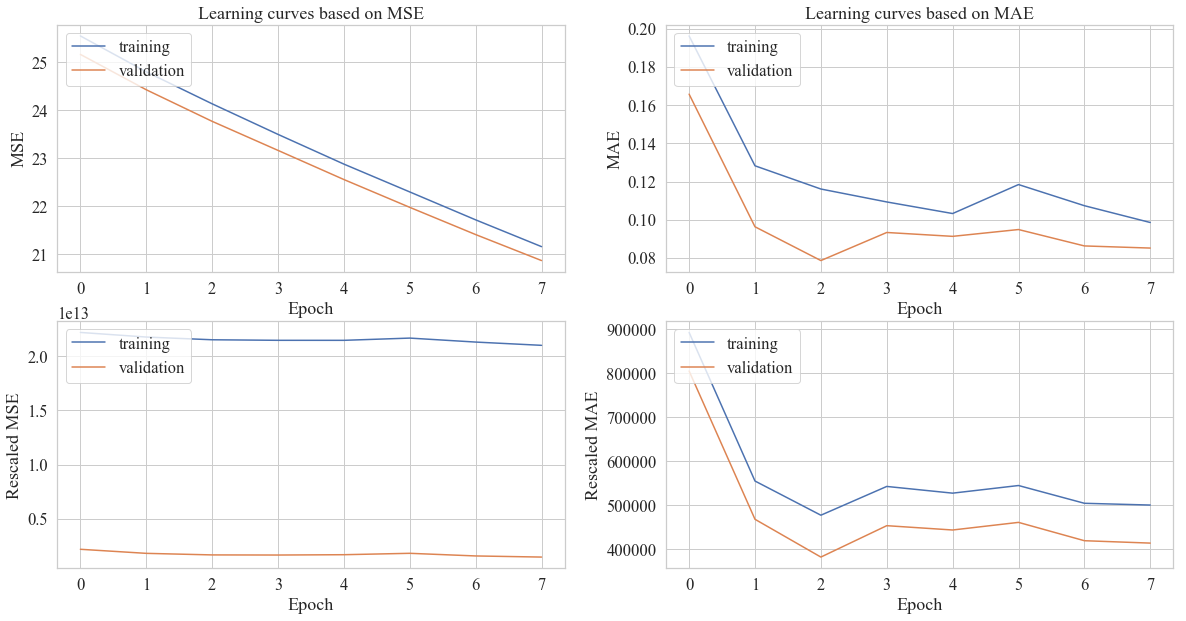

In [16]:
# summarize history for loss
#print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()
#fig.savefig("figures/training-best-nn-6-64.png", bbox_inches='tight', dpi=600)

In [20]:
test_data = log_prior.sample(2000)
model_prediction = np.apply_along_axis(log_likelihood, 1, test_data)
emu_prediction = np.apply_along_axis(emu, 1, test_data)

mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

30.65833060286393

In [34]:
# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCController(log_posterior_emu, 3, x0)
mcmc.set_max_iterations(10000)
#mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
chains_emu = mcmc.run()
print('Done!')

end = time.time()
diff = end - start

Running
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.333     0         0          0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.333     0.286     0.333      0:00.1
40    123    0.317     0.293     0.268      0:00.1
60    183    0.262     0.279     0.262      0:00.2
80    243    0.235     0.247     0.222      0:00.2
100   303    0.188     0.218     0.238      0:00.2
120   363    0.19      0.182     0.214876   0:00.2
140   423    0.163     0.17      0.191      0:00.3
160   483    0.155     0.186     0.173913   0:00.3
180   543    0.155     0.193     0.155      0:00.3
Initial phase completed.
200   603    0.144     0.189     0.144      0:00.4
220   663    0.145     0.195     0.149      0:00.4
240   723    0.149     0.186722  0.158      0:00.5
260 

3180  9543   0.269     0.24      0.227      0:07.0
3200  9603   0.268666  0.239     0.226      0:07.1
3220  9663   0.269     0.238     0.224154   0:07.1
3240  9723   0.27      0.236     0.223      0:07.1
3260  9783   0.27      0.235     0.221      0:07.2
3280  9843   0.271     0.233     0.22       0:07.2
3300  9903   0.27113   0.232     0.219      0:07.2
3320  9963   0.272     0.231     0.217      0:07.3
3340  10023  0.272     0.229     0.216103   0:07.3
3360  10083  0.272     0.228     0.214817   0:07.4
3380  10143  0.271     0.226856  0.214      0:07.4
3400  10203  0.272     0.226     0.212      0:07.4
3420  10263  0.274     0.224     0.211      0:07.5
3440  10323  0.276     0.223     0.21       0:07.5
3460  10383  0.277     0.222     0.209      0:07.6
3480  10443  0.278     0.221     0.207      0:07.6
3500  10503  0.277     0.219     0.206      0:07.6
3520  10563  0.275     0.218     0.205      0:07.7
3540  10623  0.274     0.217     0.204      0:07.7
3560  10683  0.273     0.216   

6440  19323  0.233     0.263     0.249      0:14.3
6460  19383  0.233     0.262     0.249      0:14.3
6480  19443  0.234     0.263     0.25       0:14.4
6500  19503  0.235     0.265     0.250423   0:14.5
6520  19563  0.236     0.265     0.251      0:14.5
6540  19623  0.236     0.265     0.252255   0:14.6
6560  19683  0.236     0.264     0.254      0:14.6
6580  19743  0.237046  0.263     0.254      0:14.7
6600  19803  0.237     0.262     0.255      0:14.7
6620  19863  0.237     0.262     0.256      0:14.8
6640  19923  0.239     0.261     0.256      0:14.9
6660  19983  0.24      0.26      0.256      0:14.9
6680  20043  0.239     0.259     0.256      0:14.9
6700  20103  0.239     0.259     0.257      0:15.0
6720  20163  0.24      0.258     0.257      0:15.0
6740  20223  0.241     0.257     0.258      0:15.1
6760  20283  0.241     0.256323  0.259      0:15.2
6780  20343  0.241     0.255567  0.259      0:15.2
6800  20403  0.241     0.255     0.259      0:15.3
6820  20463  0.242     0.254   

9680  29043  0.215     0.212478  0.242      0:21.4
9700  29103  0.215     0.213     0.242      0:21.4
9720  29163  0.215     0.214     0.242      0:21.5
9740  29223  0.215     0.214     0.242      0:21.5
9760  29283  0.216     0.214     0.241      0:21.6
9780  29343  0.216     0.214     0.242      0:21.6
9800  29403  0.217     0.215     0.241608   0:21.7
9820  29463  0.217     0.216     0.242      0:21.7
9840  29523  0.217     0.216     0.242      0:21.8
9860  29583  0.218     0.216     0.242      0:21.8
9880  29643  0.219     0.217     0.242      0:21.9
9900  29703  0.219     0.217     0.243      0:21.9
9920  29763  0.22      0.217     0.242      0:22.0
9940  29823  0.221     0.218     0.242      0:22.0
9960  29883  0.221     0.219     0.243      0:22.1
9980  29943  0.22      0.219     0.243      0:22.1
10000 30000  0.2202    0.2199    0.2432     0:22.2
Halting: Maximum number of iterations (10000) reached.
Done!


In [35]:
results = pints.MCMCSummary(chains=chains_emu, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
k2       1.05    0.27    1.00    1.00   1.00   1.05   1.09     1.01    214.77  9.69
k3       6.88    1.56    4.99    5.01   6.92   8.70   8.89     7.34    40.32   1.82
m1       0.76    0.29    0.36    0.37   0.89   1.00   1.00     5.52    126.12  5.69
m2       0.04    0.04    0.01    0.01   0.03   0.08   0.08     1.48    296.17  13.37
m3       0.13    0.16    0.01    0.01   0.01   0.31   0.38     7.06    211.19  9.53


In [44]:
# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
sigma0 = np.array(real_parameters) * 5e-05
mcmc = pints.MCMCController(log_posterior, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
mcmc.set_max_iterations(10000)
#mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
metropolis_chains = mcmc.run()
print('Done!')

end = time.time()
diff = end - start

Running
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0.5        0:00.1
2     9      0         0         0.667      0:00.2
3     12     0         0         0.75       0:00.2
20    63     0.429     0.476     0.524      0:00.9
40    123    0.463     0.463     0.439      0:01.6
60    183    0.492     0.426     0.442623   0:02.4
80    243    0.519     0.457     0.469      0:03.1
100   303    0.505     0.495     0.455      0:03.9
120   363    0.521     0.512     0.43       0:04.6
140   423    0.525     0.496     0.447      0:05.3
160   483    0.515528  0.491     0.472      0:06.0
180   543    0.519337  0.519337  0.47       0:06.7
200   603    0.507     0.522     0.493      0:07.3
220   663    0.511     0.516     0.498      0:08.0
240   723    0.523     0.531     0.498      0:08.8
260   783    0.517     0.532567  0.502    

3100  9303   0.337     0.278     0.284      0:52.6
3120  9363   0.335     0.277     0.283      0:52.8
3140  9423   0.334     0.276     0.282      0:53.0
3160  9483   0.332     0.276     0.281      0:53.2
3180  9543   0.331     0.275     0.279      0:53.5
3200  9603   0.329     0.275     0.278      0:53.7
3220  9663   0.329     0.274     0.277      0:53.9
3240  9723   0.327     0.273     0.276      0:54.1
3260  9783   0.326     0.272     0.274149   0:54.3
3280  9843   0.324     0.272     0.273      0:54.5
3300  9903   0.324     0.27113   0.272      0:54.8
3320  9963   0.322     0.27      0.271      0:55.0
3340  10023  0.320862  0.269     0.271      0:55.2
3360  10083  0.32      0.26867   0.27       0:55.4
3380  10143  0.32      0.269     0.269      0:55.6
3400  10203  0.319     0.268     0.268      0:55.8
3420  10263  0.319     0.267     0.266881   0:56.0
3440  10323  0.318     0.268     0.265      0:56.3
3460  10383  0.316     0.266397  0.264      0:56.5
3480  10443  0.315     0.266   

6320  18963  0.221     0.218     0.19       1:28.3
6340  19023  0.22047   0.218     0.18956    1:28.5
6360  19083  0.22      0.218     0.189      1:28.8
6380  19143  0.22      0.218     0.189      1:29.0
6400  19203  0.219     0.218     0.188      1:29.2
6420  19263  0.219     0.219     0.188      1:29.4
6440  19323  0.218     0.219     0.188      1:29.7
6460  19383  0.218     0.219     0.186968   1:30.0
6480  19443  0.218     0.219     0.187      1:30.2
6500  19503  0.218     0.219     0.187      1:30.4
6520  19563  0.217298  0.219     0.186      1:30.6
6540  19623  0.217     0.218     0.186      1:30.8
6560  19683  0.217     0.218     0.185      1:31.1
6580  19743  0.216     0.218     0.185      1:31.3
6600  19803  0.216     0.218     0.184366   1:31.5
6620  19863  0.216     0.218396  0.184      1:31.7
6640  19923  0.216     0.218     0.183      1:32.0
6660  19983  0.215283  0.218     0.183      1:32.2
6680  20043  0.215     0.218     0.183      1:32.4
6700  20103  0.215     0.218   

9540  28623  0.193     0.195     0.156      2:03.5
9560  28683  0.192     0.195     0.156      2:03.7
9580  28743  0.192     0.195     0.156      2:03.9
9600  28803  0.191855  0.195     0.156      2:04.1
9620  28863  0.192     0.195     0.156      2:04.3
9640  28923  0.191     0.194     0.156      2:04.5
9660  28983  0.190974  0.194     0.155      2:04.7
9680  29043  0.191096  0.194     0.155046   2:04.9
9700  29103  0.191     0.194     0.155      2:05.1
9720  29163  0.191     0.194     0.155      2:05.3
9740  29223  0.19      0.194     0.154      2:05.5
9760  29283  0.190042  0.193935  0.154      2:05.7
9780  29343  0.19      0.194     0.154      2:06.0
9800  29403  0.189     0.194     0.154      2:06.2
9820  29463  0.189     0.194     0.153854   2:06.4
9840  29523  0.188802  0.194     0.154      2:06.6
9860  29583  0.189     0.193     0.153      2:06.8
9880  29643  0.189     0.193     0.153      2:07.0
9900  29703  0.188     0.193     0.153      2:07.2
9920  29763  0.188     0.194   

In [45]:
metropolis_results = pints.MCMCSummary(chains=metropolis_chains, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(metropolis_results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       4.86    0.91    3.33    4.01   4.97   5.55   6.58     1.96    9.58   0.07
k3       6.38    1.93    2.82    5.19   6.44   7.58   9.99     2.36    9.00   0.07
m1       0.27    0.22    0.03    0.09   0.22   0.44   0.72     1.89    16.43  0.13
m2       0.19    0.14    0.02    0.10   0.14   0.31   0.46     1.70    21.73  0.17
m3       0.18    0.07    0.07    0.13   0.18   0.22   0.29     1.74    15.29  0.12


In [36]:
# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
sigma0 = np.array(real_parameters) * 5e-05
mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
mcmc.set_max_iterations(10000)
#mcmc.set_log_to_screen(False)

start = time.time()

print('Running')
chains_emu = mcmc.run()
print('Done!')

end = time.time()
diff = end - start

Running
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0.333     0.667     0.667      0:00.0
3     12     0.25      0.5       0.5        0:00.0
20    63     0.286     0.571     0.524      0:00.1
40    123    0.366     0.488     0.366      0:00.1
60    183    0.459     0.492     0.426      0:00.2
80    243    0.469     0.432     0.432      0:00.2
100   303    0.465     0.436     0.475      0:00.3
120   363    0.455     0.446281  0.504      0:00.3
140   423    0.461     0.461     0.489      0:00.4
160   483    0.484472  0.453     0.472      0:00.4
180   543    0.503     0.480663  0.497      0:00.5
200   603    0.507     0.483     0.507      0:00.5
220   663    0.502     0.479638  0.516      0:00.6
240   723    0.51      0.465     0.515      0:00.6
260   783    0.502     0.46      0.51341  

3100  9303   0.234     0.247     0.239      0:06.5
3120  9363   0.233     0.245     0.237      0:06.5
3140  9423   0.232     0.244     0.236      0:06.5
3160  9483   0.232     0.243     0.234      0:06.6
3180  9543   0.230745  0.242     0.233      0:06.6
3200  9603   0.229     0.241     0.231      0:06.6
3220  9663   0.228     0.239     0.23       0:06.7
3240  9723   0.227     0.237581  0.229      0:06.7
3260  9783   0.226     0.236     0.228      0:06.7
3280  9843   0.225541  0.235     0.226      0:06.8
3300  9903   0.225     0.233     0.225      0:06.8
3320  9963   0.224     0.232     0.223      0:06.8
3340  10023  0.223     0.23      0.222      0:06.9
3360  10083  0.221     0.229     0.221      0:06.9
3380  10143  0.220349  0.228     0.219      0:06.9
3400  10203  0.219     0.226404  0.218      0:06.9
3420  10263  0.218     0.225     0.217      0:07.0
3440  10323  0.218     0.224     0.215635   0:07.0
3460  10383  0.217     0.222     0.214      0:07.0
3480  10443  0.215     0.221   

6360  19083  0.12      0.122465  0.121      0:10.6
6380  19143  0.12      0.122     0.12       0:10.6
6400  19203  0.119     0.122     0.119825   0:10.6
6420  19263  0.119     0.121     0.12       0:10.7
6440  19323  0.118     0.120944  0.119      0:10.7
6460  19383  0.118     0.121     0.119      0:10.7
6480  19443  0.118     0.12      0.119      0:10.7
6500  19503  0.117     0.12      0.118      0:10.8
6520  19563  0.117     0.119     0.118      0:10.8
6540  19623  0.117     0.119     0.118      0:10.8
6560  19683  0.116     0.119     0.117      0:10.8
6580  19743  0.116     0.118     0.117      0:10.8
6600  19803  0.116     0.118     0.116649   0:10.9
6620  19863  0.115     0.117807  0.116      0:10.9
6640  19923  0.115     0.117     0.116      0:10.9
6660  19983  0.115     0.117     0.116      0:10.9
6680  20043  0.114     0.116749  0.116      0:11.0
6700  20103  0.114     0.116     0.116      0:11.0
6720  20163  0.114     0.116     0.115      0:11.0
6740  20223  0.113188  0.116   

9720  29163  0.0794    0.0811    0.0826     0:14.6
9740  29223  0.0793    0.0809    0.0824     0:14.7
9760  29283  0.0791    0.0807    0.0823     0:14.7
9780  29343  0.0789    0.0806    0.0821     0:14.7
9800  29403  0.0788    0.0804    0.0819     0:14.7
9820  29463  0.0786    0.0802    0.0818     0:14.7
9840  29523  0.0784    0.0801    0.0816     0:14.8
9860  29583  0.0783    0.0799    0.0814     0:14.8
9880  29643  0.0781    0.0797    0.0813     0:14.8
9900  29703  0.078     0.0796    0.0812     0:14.8
9920  29763  0.0778    0.0794    0.081      0:14.9
9940  29823  0.0777    0.0793    0.0809     0:14.9
9960  29883  0.0776    0.0791    0.0807     0:14.9
9980  29943  0.0774    0.079     0.0806     0:15.0
10000 30000  0.0773    0.0788    0.0804     0:15.0
Halting: Maximum number of iterations (10000) reached.
Done!


In [37]:
results = pints.MCMCSummary(chains=chains_emu, time=diff,
                            parameter_names=["k2", "k3", "m1", "m2", "m3"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       1.46    0.91    1.00    1.00   1.00   1.42   4.40     1.18    16.28  1.09
k3       8.43    0.91    5.57    8.11   8.75   9.02   9.21     1.31    16.59  1.11
m1       0.36    0.02    0.30    0.35   0.36   0.37   0.41     1.08    47.85  3.19
m2       0.04    0.10    0.01    0.01   0.01   0.01   0.42     1.06    37.63  2.51
m3       0.36    0.04    0.26    0.33   0.37   0.38   0.43     1.15    26.35  1.76


Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0.333     0.333      0:00.1
3     12     0.25      0.5       0.5        0:00.2
20    63     0.19      0.0952    0.143      0:01.0
40    123    0.146     0.122     0.146      0:02.3
60    183    0.18      0.147541  0.0984     0:03.1
80    243    0.173     0.136     0.0864     0:03.9
100   303    0.168     0.129     0.0891     0:04.8
120   363    0.157     0.132     0.0744     0:05.6
140   423    0.17      0.135     0.0851     0:06.5
160   483    0.161     0.13      0.087      0:07.3
180   543    0.155     0.138     0.0829     0:08.1
200   603    0.154     0.129     0.0846     0:08.9
220   663    0.158371  0.145     0.0769     0:09.8
240   723    0.166     0.137     0.0913     0:10.7
260   783    0.172     0.134     0.092    

3100  9303   0.0461    0.049     0.0448     1:30.0
3120  9363   0.0458    0.0487    0.0445     1:30.4
3140  9423   0.0462    0.0484    0.0443     1:30.8
3160  9483   0.0459    0.0481    0.044      1:31.2
3180  9543   0.0456    0.0478    0.0437     1:31.7
3200  9603   0.0453    0.0475    0.0434     1:32.1
3220  9663   0.0453    0.0475    0.0432     1:32.5
3240  9723   0.045     0.0478    0.042888   1:32.9
3260  9783   0.0448    0.0478    0.0426     1:33.4
3280  9843   0.0448    0.0475    0.0427     1:33.8
3300  9903   0.0445    0.0476    0.0424     1:34.2
3320  9963   0.0446    0.0473    0.0422     1:34.5
3340  10023  0.0446    0.0473    0.0419     1:34.9
3360  10083  0.0443    0.047     0.0417     1:35.4
3380  10143  0.0441    0.0467    0.0414     1:35.8
3400  10203  0.0438    0.0465    0.0412     1:36.2
3420  10263  0.0436    0.0462    0.0409     1:36.6
3440  10323  0.0436    0.0459    0.0407     1:37.0
3460  10383  0.0433    0.0457    0.0405     1:37.4
3480  10443  0.0431    0.0454  

6320  18963  0.0266    0.0275    0.0244     2:49.4
6340  19023  0.0265    0.0274    0.0243     2:49.9
6360  19083  0.0264    0.0274    0.0242     2:50.3
6380  19143  0.0263    0.0273    0.0241     2:50.8
6400  19203  0.0262    0.0272    0.0241     2:51.2
6420  19263  0.0262    0.0271    0.024      2:51.6
6440  19323  0.0261    0.027     0.0239     2:52.0
6460  19383  0.026     0.0269    0.0238     2:52.5
6480  19443  0.0259    0.0268    0.0238     2:52.8
6500  19503  0.0258    0.0268    0.0237     2:53.2
6520  19563  0.0258    0.0268    0.0236     2:53.6
6540  19623  0.0257    0.0268    0.0235     2:54.0
6560  19683  0.0256    0.0267    0.0235     2:54.4
6580  19743  0.0255    0.0266    0.0234     2:54.8
6600  19803  0.0255    0.0265    0.0233     2:55.2
6620  19863  0.0255    0.0264    0.0233     2:55.7
6640  19923  0.0254    0.0264    0.0232     2:56.2
6660  19983  0.0254    0.0263    0.0231     2:56.6
6680  20043  0.0253    0.0262    0.0231     2:57.0
6700  20103  0.0252    0.0261  

9540  28623  0.0195    0.0201    0.0173     4:02.7
9560  28683  0.0195    0.0201    0.0173     4:03.2
9580  28743  0.0194    0.02      0.0172     4:03.6
9600  28803  0.0194    0.02      0.0172     4:04.0
9620  28863  0.0193    0.02      0.0171     4:04.5
9640  28923  0.0193    0.0199    0.0171     4:05.0
9660  28983  0.0193    0.0199    0.0171     4:05.4
9680  29043  0.0192    0.0198    0.017      4:05.8
9700  29103  0.0192    0.0198    0.017      4:06.3
9720  29163  0.0191    0.0198    0.017      4:06.8
9740  29223  0.0191    0.0198    0.0169     4:07.2
9760  29283  0.0191    0.0198    0.0169     4:07.6
9780  29343  0.019     0.0197    0.0169     4:08.1
9800  29403  0.019     0.0197    0.0168     4:08.6
9820  29463  0.0191    0.0197    0.0169     4:09.0
9840  29523  0.0191    0.0196    0.0169     4:09.5
9860  29583  0.019065  0.0196    0.0169     4:10.0
9880  29643  0.019     0.0195    0.0169     4:10.4
9900  29703  0.019     0.0195    0.0169     4:10.8
9920  29763  0.0189    0.0195  

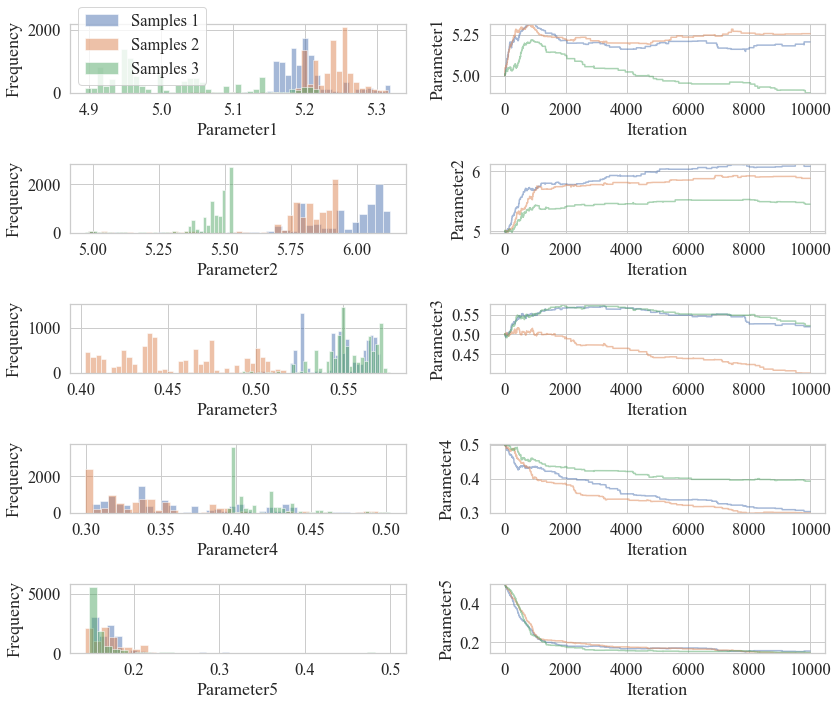

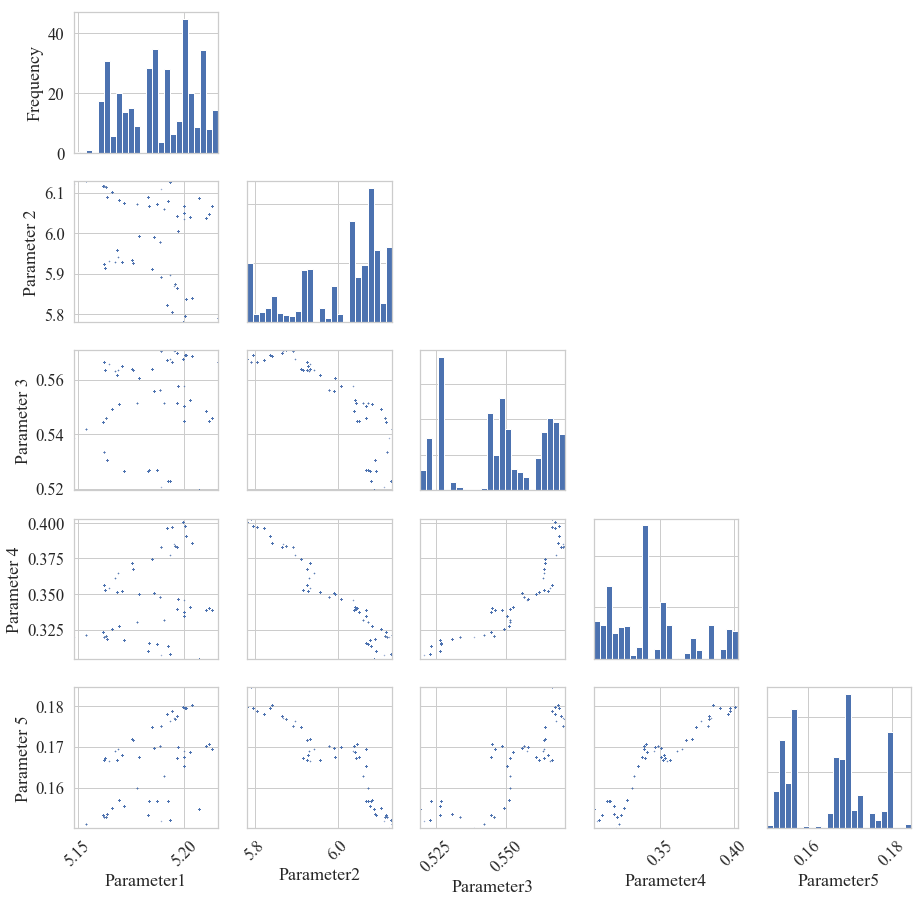

In [38]:
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(real_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [39]:
acceptance_rates = mcmc.acceptance_rates()
acceptance_rates

[(0.018799999999999966, 0.5022000000000021, 0.037435284747112704),
 (0.019300000000000005, 0.5001999999999999, 0.038584566173530586),
 (0.01670000000000006, 0.495, 0.03373737373737374)]